# **CIBMTR - Equity in post-HCT Survival Predictions Soluntion**
<h4><b> Notebook Ensembles </b></h4>

- Event-masked PRL-NN+Classifier
- 4 targets Ensemble Model
- Classifier+CAT+XGB

---

# **Event-masked PRL-NN**


In [1]:
!pip install -q /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install -q /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install -q /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install -q /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install -q /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/pytorch_lightning-2.4.0-py3-none-any.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/scikit_learn-1.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/torchmetrics-1.5.2-py3-none-any.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/pytorch_tabnet-4.1.0-py3-none-any.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/einops-0.7.0-py3-none-any.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/pytorch_tabular-1.1.1-py2.py3-none-any.whl

  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.


## XGB Classifier to mask further predictions

In [2]:
from pathlib import Path
from metric import score
import pandas as pd
import numpy as np
from warnings import filterwarnings
filterwarnings('ignore')

ROOT_DATA_PATH = Path(r"/kaggle/input/equity-post-HCT-survival-predictions")

pd.set_option('display.max_columns', 100)

train = pd.read_csv(ROOT_DATA_PATH.joinpath("train.csv"))
test = pd.read_csv(ROOT_DATA_PATH.joinpath("test.csv"))

CATEGORICAL_VARIABLES = [
    # Graft and HCT reasons
    'dri_score', 'graft_type', 'prod_type', 'prim_disease_hct',

    # Patient health status (risk factors)
    'psych_disturb', 'diabetes', 'arrhythmia', 'vent_hist', 'renal_issue', 'pulm_moderate',
    'pulm_severe', 'obesity', 'hepatic_mild', 'hepatic_severe', 'peptic_ulcer', 'rheum_issue',
    'cardiac', 'prior_tumor', 'mrd_hct', 'tbi_status', 'cyto_score', 'cyto_score_detail', 

    # Patient demographics
    'ethnicity', 'race_group',

    # Biological matching with donor
    'sex_match', 'donor_related', 'cmv_status', 'tce_imm_match', 'tce_match', 'tce_div_match',

    # Medication/operation related data
    'melphalan_dose', 'rituximab', 'gvhd_proph', 'in_vivo_tcd', 'conditioning_intensity'
]

HLA_COLUMNS = [
    'hla_match_a_low', 'hla_match_a_high',
    'hla_match_b_low', 'hla_match_b_high',
    'hla_match_c_low', 'hla_match_c_high',
    'hla_match_dqb1_low', 'hla_match_dqb1_high',
    'hla_match_drb1_low', 'hla_match_drb1_high',
    
    # Matching at HLA-A(low), -B(low), -DRB1(high)
    'hla_nmdp_6',
    # Matching at HLA-A,-B,-DRB1 (low or high)
    'hla_low_res_6', 'hla_high_res_6',
    # Matching at HLA-A, -B, -C, -DRB1 (low or high)
    'hla_low_res_8', 'hla_high_res_8',
    # Matching at HLA-A, -B, -C, -DRB1, -DQB1 (low or high)
    'hla_low_res_10', 'hla_high_res_10'
]

OTHER_NUMERICAL_VARIABLES = ['year_hct', 'donor_age', 'age_at_hct', 'comorbidity_score', 'karnofsky_score']
NUMERICAL_VARIABLES = HLA_COLUMNS + OTHER_NUMERICAL_VARIABLES

TARGET_VARIABLES = ['efs_time', 'efs']
ID_COLUMN = ["ID"]


def preprocess_data(df):
    df[CATEGORICAL_VARIABLES] = df[CATEGORICAL_VARIABLES].fillna("Unknown")
    df[OTHER_NUMERICAL_VARIABLES] = df[OTHER_NUMERICAL_VARIABLES].fillna(df[OTHER_NUMERICAL_VARIABLES].median())

    return df

train = preprocess_data(train)
test = preprocess_data(test)


def features_engineering(df):
    # Change year_hct to relative year from 2000
    df['year_hct'] = df['year_hct'] - 2000
    
    return df


train = features_engineering(train)
test = features_engineering(test)

train[CATEGORICAL_VARIABLES] = train[CATEGORICAL_VARIABLES].astype('category')
test[CATEGORICAL_VARIABLES] = test[CATEGORICAL_VARIABLES].astype('category')

FEATURES = train.drop(columns=['ID', 'efs', 'efs_time']).columns.tolist()

In [3]:
from xgboost import XGBRegressor, XGBClassifier
import xgboost
print("Using XGBoost version",xgboost.__version__)
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

FOLDS = 5
kf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_xgb = np.zeros(len(train))
pred_efs = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train, train["efs"])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, "efs"]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, "efs"]
    x_test = test[FEATURES].copy()

    model_xgb = XGBClassifier(
     
        max_depth=3,  
        colsample_bytree=0.7129400756425178, 
        subsample=0.8185881823156917, 
        n_estimators=20_000, 
        learning_rate=0.04425768131771064,  
        eval_metric="auc", 
        early_stopping_rounds=50, 
        objective='binary:logistic',
        scale_pos_weight=1.5379160847615545,  
        min_child_weight=4,
        enable_categorical=True,
        gamma=3.1330719334577584
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=100
    )

    # INFER OOF (Probabilities -> Binary)
    oof_xgb[test_index] = (model_xgb.predict_proba(x_valid)[:, 1] > 0.5).astype(int)
    # INFER TEST (Probabilities -> Average Probs)
    pred_efs += model_xgb.predict_proba(x_test)[:, 1]

# COMPUTE AVERAGE TEST PREDS
pred_efs = (pred_efs / FOLDS > 0.5).astype(int)

# EVALUATE PERFORMANCE
accuracy = accuracy_score(train["efs"], oof_xgb)
f1 = f1_score(train["efs"], oof_xgb)
roc_auc = roc_auc_score(train["efs"], oof_xgb)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

Using XGBoost version 2.0.3
#########################
### Fold 1
#########################
[0]	validation_0-auc:0.65449
[100]	validation_0-auc:0.72596
[200]	validation_0-auc:0.73445
[300]	validation_0-auc:0.73902
[400]	validation_0-auc:0.74167
[500]	validation_0-auc:0.74280
[600]	validation_0-auc:0.74342
[700]	validation_0-auc:0.74408
[800]	validation_0-auc:0.74439
[822]	validation_0-auc:0.74436
#########################
### Fold 2
#########################
[0]	validation_0-auc:0.67284
[100]	validation_0-auc:0.75066
[200]	validation_0-auc:0.75853
[300]	validation_0-auc:0.76227
[400]	validation_0-auc:0.76397
[500]	validation_0-auc:0.76506
[600]	validation_0-auc:0.76573
[700]	validation_0-auc:0.76588
[741]	validation_0-auc:0.76576
#########################
### Fold 3
#########################
[0]	validation_0-auc:0.67150
[100]	validation_0-auc:0.74859
[200]	validation_0-auc:0.75641
[300]	validation_0-auc:0.76023
[400]	validation_0-auc:0.76171
[454]	validation_0-auc:0.76151
##############

## Prepare data

Below are a few utility functions to load and prepare the data for training with pytorch.

In [4]:
import numpy as np
import pandas as pd
import torch
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import TensorDataset
from warnings import filterwarnings

filterwarnings('ignore')


def get_X_cat(df, cat_cols, transformers=None):
    """
    Apply a specific categorical data transformer or a LabelEncoder if None.
    """
    if transformers is None:
        transformers = [LabelEncoder().fit(df[col]) for col in cat_cols]
    return transformers, np.array(
        [transformer.transform(df[col]) for col, transformer in zip(cat_cols, transformers)]
    ).T


def preprocess_data(train, val):
    """
    Standardize numerical variables and transform (Label-encode) categoricals.
    Fill NA values with mean for numerical.
    Create torch dataloaders to prepare data for training and evaluation.
    """
    X_cat_train, X_cat_val, numerical, transformers = get_categoricals(train, val)
    scaler = StandardScaler()
    imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
    X_num_train = imp.fit_transform(train[numerical])
    X_num_train = scaler.fit_transform(X_num_train)
    X_num_val = imp.transform(val[numerical])
    X_num_val = scaler.transform(X_num_val)
    dl_train = init_dl(X_cat_train, X_num_train, train, training=True)
    dl_val = init_dl(X_cat_val, X_num_val, val)
    return X_cat_val, X_num_train, X_num_val, dl_train, dl_val, transformers


def get_categoricals(train, val):
    """
    Remove constant categorical columns and transform them using LabelEncoder.
    Return the label-transformers for each categorical column, categorical dataframes and numerical columns.
    """
    categorical_cols, numerical = get_feature_types(train)
    remove = []
    for col in categorical_cols:
        if train[col].nunique() == 1:
            remove.append(col)
        ind = ~val[col].isin(train[col])
        if ind.any():
            val.loc[ind, col] = np.nan
    categorical_cols = [col for col in categorical_cols if col not in remove]
    transformers, X_cat_train = get_X_cat(train, categorical_cols)
    _, X_cat_val = get_X_cat(val, categorical_cols, transformers)
    return X_cat_train, X_cat_val, numerical, transformers


def init_dl(X_cat, X_num, df, training=False):
    """
    Initialize data loaders with 4 dimensions : categorical dataframe, numerical dataframe and target values (efs and efs_time).
    Notice that efs_time is log-transformed.
    Fix batch size to 2048 and return dataloader for training or validation depending on training value.
    """
    ds_train = TensorDataset(
        torch.tensor(X_cat, dtype=torch.long),
        torch.tensor(X_num, dtype=torch.float32),
        torch.tensor(df.efs_time.values, dtype=torch.float32).log(),
        torch.tensor(df.efs.values, dtype=torch.long)
    )
    bs = 2048
    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=bs, pin_memory=True, shuffle=training)
    return dl_train


def get_feature_types(train):
    """
    Utility function to return categorical and numerical column names.
    """
    categorical_cols = [col for i, col in enumerate(train.columns) if ((train[col].dtype == "object") | (2 < train[col].nunique() < 25))]
    RMV = ["ID", "efs", "efs_time", "y"]
    FEATURES = [c for c in train.columns if not c in RMV]
    numerical = [i for i in FEATURES if i not in categorical_cols]
    return categorical_cols, numerical


def add_features(df):
    """
    Create some new features to help the model focus on specific patterns.
    """
    # sex_match = df.sex_match.astype(str)
    # sex_match = sex_match.str.split("-").str[0] == sex_match.str.split("-").str[1]
    # df['sex_match_bool'] = sex_match
    # df.loc[df.sex_match.isna(), 'sex_match_bool'] = np.nan
    # df['big_age'] = df.age_at_hct > 16
    # df.loc[df.year_hct == 2019, 'year_hct'] = 2020
    df['is_cyto_score_same'] = (df['cyto_score'] == df['cyto_score_detail']).astype(int)
    # df['strange_age'] = df.age_at_hct == 0.044
    # df['age_bin'] = pd.cut(df.age_at_hct, [0, 0.0441, 16, 30, 50, 100])
    # df['age_ts'] = df.age_at_hct / df.donor_age
    df['year_hct'] -= 2000
    
    return df


def load_data():
    """
    Load data and add features.
    """
    test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
    test = add_features(test)
    print("Test shape:", test.shape)
    train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
    train = add_features(train)
    print("Train shape:", train.shape)
    return test, train

## Define models with pairwise ranking loss

The model is defined in 3 steps :
* Embedding class for categorical data
* MLP for numerical and categorical data
* Final model trained with pairwise ranking loss with selection of valid pairs

In [5]:
import functools
from typing import List

import pytorch_lightning as pl
import numpy as np
import torch
from lifelines.utils import concordance_index
from pytorch_lightning.cli import ReduceLROnPlateau
from pytorch_tabular.models.common.layers import ODST
from torch import nn
from pytorch_lightning.utilities import grad_norm


class CatEmbeddings(nn.Module):
    """
    Embedding module for the categorical dataframe.
    """
    def __init__(
        self,
        projection_dim: int,
        categorical_cardinality: List[int],
        embedding_dim: int
    ):
        """
        projection_dim: The dimension of the final output after projecting the concatenated embeddings into a lower-dimensional space.
        categorical_cardinality: A list where each element represents the number of unique categories (cardinality) in each categorical feature.
        embedding_dim: The size of the embedding space for each categorical feature.
        self.embeddings: list of embedding layers for each categorical feature.
        self.projection: sequential neural network that goes from the embedding to the output projection dimension with GELU activation.
        """
        super(CatEmbeddings, self).__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(cardinality, embedding_dim)
            for cardinality in categorical_cardinality
        ])
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim * len(categorical_cardinality), projection_dim),
            nn.GELU(),
            nn.Linear(projection_dim, projection_dim)
        )

    def forward(self, x_cat):
        """
        Apply the projection on concatened embeddings that contains all categorical features.
        """
        x_cat = [embedding(x_cat[:, i]) for i, embedding in enumerate(self.embeddings)]
        x_cat = torch.cat(x_cat, dim=1)
        return self.projection(x_cat)


class NN(nn.Module):
    """
    Train a model on both categorical embeddings and numerical data.
    """
    def __init__(
            self,
            continuous_dim: int,
            categorical_cardinality: List[int],
            embedding_dim: int,
            projection_dim: int,
            hidden_dim: int,
            dropout: float = 0
    ):
        """
        continuous_dim: The number of continuous features.
        categorical_cardinality: A list of integers representing the number of unique categories in each categorical feature.
        embedding_dim: The dimensionality of the embedding space for each categorical feature.
        projection_dim: The size of the projected output space for the categorical embeddings.
        hidden_dim: The number of neurons in the hidden layer of the MLP.
        dropout: The dropout rate applied in the network.
        self.embeddings: previous embeddings for categorical data.
        self.mlp: defines an MLP model with an ODST layer followed by batch normalization and dropout.
        self.out: linear output layer that maps the output of the MLP to a single value
        self.dropout: defines dropout
        Weights initialization with xavier normal algorithm and biases with zeros.
        """
        super(NN, self).__init__()
        self.embeddings = CatEmbeddings(projection_dim, categorical_cardinality, embedding_dim)
        self.mlp = nn.Sequential(
            ODST(projection_dim + continuous_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout)
        )
        self.out = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)

        # initialize weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x_cat, x_cont):
        """
        Create embedding layers for categorical data, concatenate with continous variables.
        Add dropout and goes through MLP and return raw output and 1-dimensional output as well.
        """
        x = self.embeddings(x_cat)
        x = torch.cat([x, x_cont], dim=1)
        x = self.dropout(x)
        x = self.mlp(x)
        return self.out(x), x


@functools.lru_cache
def combinations(N):
    """
    calculates all possible 2-combinations (pairs) of a tensor of indices from 0 to N-1, 
    and caches the result using functools.lru_cache for optimization
    """
    ind = torch.arange(N)
    comb = torch.combinations(ind, r=2)
    return comb


class LitNN(pl.LightningModule):
    """
    Main Model creation and losses definition to fully train the model.
    """
    def __init__(
            self,
            continuous_dim: int,
            categorical_cardinality: List[int],
            embedding_dim: int,
            projection_dim: int,
            hidden_dim: int,
            lr: float = 1e-3,
            dropout: float = 0.2,
            weight_decay: float = 1e-3,
            aux_weight: float = 0.1,
            margin: float = 0.5,
            race_index: int = 0
    ):
        """
        continuous_dim: The number of continuous input features.
        categorical_cardinality: A list of integers, where each element corresponds to the number of unique categories for each categorical feature.
        embedding_dim: The dimension of the embeddings for the categorical features.
        projection_dim: The dimension of the projected space after embedding concatenation.
        hidden_dim: The size of the hidden layers in the feedforward network (MLP).
        lr: The learning rate for the optimizer.
        dropout: Dropout probability to avoid overfitting.
        weight_decay: The L2 regularization term for the optimizer.
        aux_weight: Weight used for auxiliary tasks.
        margin: Margin used in some loss functions.
        race_index: An index that refer to race_group in the input data.
        """
        super(LitNN, self).__init__()
        self.save_hyperparameters()

        # Creates an instance of the NN model defined above
        self.model = NN(
            continuous_dim=self.hparams.continuous_dim,
            categorical_cardinality=self.hparams.categorical_cardinality,
            embedding_dim=self.hparams.embedding_dim,
            projection_dim=self.hparams.projection_dim,
            hidden_dim=self.hparams.hidden_dim,
            dropout=self.hparams.dropout
        )
        self.targets = []

        # Defines a small feedforward neural network that performs an auxiliary task with 1-dimensional output
        self.aux_cls = nn.Sequential(
            nn.Linear(self.hparams.hidden_dim, self.hparams.hidden_dim // 3),
            nn.GELU(),
            nn.Linear(self.hparams.hidden_dim // 3, 1)
        )

    def on_before_optimizer_step(self, optimizer):
        """
        Compute the 2-norm for each layer
        If using mixed precision, the gradients are already unscaled here
        """
        norms = grad_norm(self.model, norm_type=2)
        self.log_dict(norms)

    def forward(self, x_cat, x_cont):
        """
        Forward pass that outputs the 1-dimensional prediction and the embeddings (raw output)
        """
        x, emb = self.model(x_cat, x_cont)
        return x.squeeze(1), emb

    def training_step(self, batch, batch_idx):
        """
        defines how the model processes each batch of data during training.
        A batch is a combination of : categorical data, continuous data, efs_time (y) and efs event.
        y_hat is the efs_time prediction on all data and aux_pred is auxiliary prediction on embeddings.
        Calculates loss and race_group loss on full data.
        Auxiliary loss is calculated with an event mask, ignoring efs=0 predictions and taking the average.
        Returns loss and aux_loss multiplied by weight defined above.
        """
        x_cat, x_cont, y, efs = batch
        y_hat, emb = self(x_cat, x_cont)
        aux_pred = self.aux_cls(emb).squeeze(1)
        loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
        aux_loss = nn.functional.mse_loss(aux_pred, y, reduction='none')
        aux_mask = efs == 1
        aux_loss = (aux_loss * aux_mask).sum() / aux_mask.sum()
        self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("race_loss", race_loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
        self.log("aux_loss", aux_loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
        return loss + aux_loss * self.hparams.aux_weight

    def get_full_loss(self, efs, x_cat, y, y_hat):
        """
        Output loss and race_group loss.
        """
        loss = self.calc_loss(y, y_hat, efs)
        race_loss = self.get_race_losses(efs, x_cat, y, y_hat)
        loss += 0.1 * race_loss
        return loss, race_loss

    def get_race_losses(self, efs, x_cat, y, y_hat):
        """
        Calculate loss for each race_group based on deviation/variance.
        """
        races = torch.unique(x_cat[:, self.hparams.race_index])
        race_losses = []
        for race in races:
            ind = x_cat[:, self.hparams.race_index] == race
            race_losses.append(self.calc_loss(y[ind], y_hat[ind], efs[ind]))
        race_loss = sum(race_losses) / len(race_losses)
        races_loss_std = sum((r - race_loss)**2 for r in race_losses) / len(race_losses)
        return torch.sqrt(races_loss_std)

    def calc_loss(self, y, y_hat, efs):
        """
        Most important part of the model : loss function used for training.
        We face survival data with event indicators along with time-to-event.

        This function computes the main loss by the following the steps :
        * create all data pairs with "combinations" function (= all "two subjects" combinations)
        * make sure that we have at least 1 event in each pair
        * convert y to +1 or -1 depending on the correct ranking
        * loss is computed using a margin-based hinge loss
        * mask is applied to ensure only valid pairs are being used (censored data can't be ranked with event in some cases)
        * average loss on all pairs is returned
        """
        N = y.shape[0]
        comb = combinations(N)
        comb = comb[(efs[comb[:, 0]] == 1) | (efs[comb[:, 1]] == 1)]
        pred_left = y_hat[comb[:, 0]]
        pred_right = y_hat[comb[:, 1]]
        y_left = y[comb[:, 0]]
        y_right = y[comb[:, 1]]
        y = 2 * (y_left > y_right).int() - 1
        loss = nn.functional.relu(-y * (pred_left - pred_right) + self.hparams.margin)
        mask = self.get_mask(comb, efs, y_left, y_right)
        loss = (loss.double() * (mask.double())).sum() / mask.sum()
        return loss

    def get_mask(self, comb, efs, y_left, y_right):
        """
        Defines all invalid comparisons :
        * Case 1: "Left outlived Right" but Right is censored
        * Case 2: "Right outlived Left" but Left is censored
        Masks for case 1 and case 2 are combined using |= operator and inverted using ~ to create a "valid pair mask"
        """
        left_outlived = y_left >= y_right
        left_1_right_0 = (efs[comb[:, 0]] == 1) & (efs[comb[:, 1]] == 0)
        mask2 = (left_outlived & left_1_right_0)
        right_outlived = y_right >= y_left
        right_1_left_0 = (efs[comb[:, 1]] == 1) & (efs[comb[:, 0]] == 0)
        mask2 |= (right_outlived & right_1_left_0)
        mask2 = ~mask2
        mask = mask2
        return mask

    def validation_step(self, batch, batch_idx):
        """
        This method defines how the model processes each batch during validation
        """
        x_cat, x_cont, y, efs = batch
        y_hat, emb = self(x_cat, x_cont)
        loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
        self.targets.append([y, y_hat.detach(), efs, x_cat[:, self.hparams.race_index]])
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def on_validation_epoch_end(self):
        """
        At the end of the validation epoch, it computes and logs the concordance index
        """
        cindex, metric = self._calc_cindex()
        self.log("cindex", metric, on_epoch=True, prog_bar=True, logger=True)
        self.log("cindex_simple", cindex, on_epoch=True, prog_bar=True, logger=True)
        self.targets.clear()

    def _calc_cindex(self):
        """
        Calculate c-index accounting for each race_group or global.
        """
        y = torch.cat([t[0] for t in self.targets]).cpu().numpy()
        y_hat = torch.cat([t[1] for t in self.targets]).cpu().numpy()
        efs = torch.cat([t[2] for t in self.targets]).cpu().numpy()
        races = torch.cat([t[3] for t in self.targets]).cpu().numpy()
        metric = self._metric(efs, races, y, y_hat)
        cindex = concordance_index(y, y_hat, efs)
        return cindex, metric

    def _metric(self, efs, races, y, y_hat):
        """
        Calculate c-index accounting for each race_group
        """
        metric_list = []
        for race in np.unique(races):
            y_ = y[races == race]
            y_hat_ = y_hat[races == race]
            efs_ = efs[races == race]
            metric_list.append(concordance_index(y_, y_hat_, efs_))
        metric = float(np.mean(metric_list) - np.sqrt(np.var(metric_list)))
        return metric

    def test_step(self, batch, batch_idx):
        """
        Same as training step but to log test data
        """
        x_cat, x_cont, y, efs = batch
        y_hat, emb = self(x_cat, x_cont)
        loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
        self.targets.append([y, y_hat.detach(), efs, x_cat[:, self.hparams.race_index]])
        self.log("test_loss", loss)
        return loss

    def on_test_epoch_end(self) -> None:
        """
        At the end of the test epoch, calculates and logs the concordance index for the test set
        """
        cindex, metric = self._calc_cindex()
        self.log("test_cindex", metric, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_cindex_simple", cindex, on_epoch=True, prog_bar=True, logger=True)
        self.targets.clear()


    def configure_optimizers(self):
        """
        configures the optimizer and learning rate scheduler:
        * Optimizer: Adam optimizer with weight decay (L2 regularization).
        * Scheduler: Cosine Annealing scheduler, which adjusts the learning rate according to a cosine curve.
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        scheduler_config = {
            "scheduler": torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=45,
                eta_min=6e-3
            ),
            "interval": "epoch",
            "frequency": 1,
            "strict": False,
        }

        return {"optimizer": optimizer, "lr_scheduler": scheduler_config}

In [6]:
import json
import pytorch_lightning as pl
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import torch
from pytorch_lightning.callbacks import LearningRateMonitor, TQDMProgressBar
from pytorch_lightning.callbacks import StochasticWeightAveraging
from sklearn.model_selection import StratifiedKFold

pl.seed_everything(42)

def main(hparams):
    """
    Main function to train the model.
    The steps are as following :
    * load data and fill efs and efs time for test data with 1
    * initialize pred array with 0
    * get categorical and numerical columns
    * split the train data on the stratified criterion : race_group * newborns yes/no
    * preprocess the fold data (create dataloaders)
    * train the model and create final submission output
    """
    test, train_original = load_data()
    test['efs_time'] = 1
    test['efs'] = 1
    oof_nn_pairwise = np.zeros(len(train_original))
    test_pred = np.zeros(test.shape[0])
    categorical_cols, numerical = get_feature_types(train_original)
    kf = StratifiedKFold(n_splits=5, shuffle=True, )
    for i, (train_index, test_index) in enumerate(
        kf.split(
            train_original, train_original.race_group.astype(str) + (train_original.age_at_hct == 0.044).astype(str)
        )
    ):
        tt = train_original.copy()
        train = tt.iloc[train_index]
        val = tt.iloc[test_index]
        X_cat_val, X_num_train, X_num_val, dl_train, dl_val, transformers = preprocess_data(train, val)
        model = train_final(X_num_train, dl_train, dl_val, transformers, categorical_cols=categorical_cols)
        oof_pred, _ = model.eval()(
            torch.tensor(X_cat_val, dtype=torch.long),
            torch.tensor(X_num_val, dtype=torch.float32)
        )
        oof_nn_pairwise[test_index] = oof_pred.detach().cpu().numpy()
        # Create submission
        train = tt.iloc[train_index]
        X_cat_val, X_num_train, X_num_val, dl_train, dl_val, transformers = preprocess_data(train, test)
        pred, _ = model.eval()(
            torch.tensor(X_cat_val, dtype=torch.long),
            torch.tensor(X_num_val, dtype=torch.float32)
        )
        test_pred += pred.detach().cpu().numpy()
        
    
    return -test_pred, -oof_nn_pairwise



def train_final(X_num_train, dl_train, dl_val, transformers, hparams=None, categorical_cols=None):
    """
    Defines model hyperparameters and fit the model.
    """
    if hparams is None:
        hparams = {
            "embedding_dim": 16,
            "projection_dim": 112,
            "hidden_dim": 56,
            "lr": 0.06464861983337984,
            "dropout": 0.05463240181423116,
            "aux_weight": 0.26545778308743806,
            "margin": 0.2588153271003354,
            "weight_decay": 0.0002773544957610778
        }
    model = LitNN(
        continuous_dim=X_num_train.shape[1],
        categorical_cardinality=[len(t.classes_) for t in transformers],
        race_index=categorical_cols.index("race_group"),
        **hparams
    )
    checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss", save_top_k=1)
    trainer = pl.Trainer(

        max_epochs=60,
        log_every_n_steps=6,
        callbacks=[
            checkpoint_callback,
            LearningRateMonitor(logging_interval='epoch'),
            TQDMProgressBar(),
            StochasticWeightAveraging(swa_lrs=1e-5, swa_epoch_start=45, annealing_epochs=15)
        ],
    )
    trainer.fit(model, dl_train)
    trainer.test(model, dl_val)
    return model.eval()

In [7]:
hparams = None
pairwise_ranking_pred, pairwise_ranking_oof = main(hparams)

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = pairwise_ranking_oof
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nPairwise ranking NN CV =",m)

# Update predictions with classifier mask
pairwise_ranking_oof[oof_xgb == 1] += 0.2
y_pred["prediction"] = pairwise_ranking_oof
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nPairwise ranking NN with classifier mask -> CV =",m)

pairwise_ranking_pred[pred_efs == 1] += 0.2

Test shape: (3, 59)
Train shape: (28800, 61)


Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6755250096321106     │
│    test_cindex_simple     │    0.6917833685874939     │
│         test_loss         │    0.18284108969874854    │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6759463548660278     │
│    test_cindex_simple     │    0.6854759454727173     │
│         test_loss         │    0.18524638945164548    │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6812193989753723     │
│    test_cindex_simple     │    0.6901424527168274     │
│         test_loss         │    0.1838206190220139     │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6823421120643616     │
│    test_cindex_simple     │    0.6962693333625793     │
│         test_loss         │    0.17942920840829343    │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6702635288238525     │
│    test_cindex_simple     │    0.6803009510040283     │
│         test_loss         │    0.18866411349116394    │
└───────────────────────────┴───────────────────────────┘


Pairwise ranking NN CV = 0.6781441330713247

Pairwise ranking NN with classifier mask -> CV = 0.679251489599185


In [8]:
subm_data = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv")
subm_data['prediction'] = pairwise_ranking_pred
subm_data.to_csv('submission1.csv', index=False)

---

# **CIBMTR | EDA & Ensemble Model**

https://www.kaggle.com/code/andreasbis/cibmtr-eda-ensemble-model

In [9]:
!pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

Processing /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
autograd is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Processing /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
  Preparing metadata (setup.py) ... done
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=b1c384cc0b9ce10238b750125232ff5afaea6d0d9ed56d5afb875d1f189f9009
  Stored in directory: /root/.cache/pip/wheels/6b/b5/e0/4c79e15c0b5f2c15ecf613c720bb20daab20a666eb67135155
Successfully built autograd-gamma
  Attempting uninstall: autograd-gamma
    Found existing installation: autograd-gamma 0.5.0
    Uninstalling autograd-gamma-0.5.0:
      Successfully uninstalled autograd-gamma-0.5.0
Processing /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
interface-meta is already installed with the same version as the provided wheel. Use --force-r

In [10]:
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

import numpy as np
import polars as pl
import pandas as pd
import plotly.colors as pc
import plotly.express as px
import plotly.graph_objects as go

import plotly.io as pio
pio.renderers.default = 'iframe'

pd.options.display.max_columns = None

from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
import lightgbm as lgb
from metric import score
from scipy.stats import rankdata 
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold

In [11]:
class CFG:

    train_path = Path('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
    test_path = Path('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')
    subm_path = Path('/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv')
    
    colorscale = 'Redor'
    color = '#A2574F'

    batch_size = 32768
    early_stop = 300
    penalizer = 0.01
    n_splits = 5

    weights = [2, 1, 6, 3, 6, 3, 6, 6]

    ctb_params = {
        'loss_function': 'RMSE',
        'learning_rate': 0.03,
        'random_state': 42,
        'task_type': 'CPU',
        'num_trees': 6000,
        'reg_lambda': 8.0,
        'depth': 8
    }
 
    lgb_params = {
        'objective': 'regression',
        'min_child_samples': 32,
        'num_iterations': 6000,
        'learning_rate': 0.03,
        'extra_trees': True,
        'reg_lambda': 8.0,
        'reg_alpha': 0.1,
        'num_leaves': 64,
        'metric': 'rmse',
        'max_depth': 8,
        'device': 'cpu',
        'max_bin': 128,
        'verbose': -1,
        'seed': 42
    }

    cox1_params = {
        'grow_policy': 'Depthwise',
        'min_child_samples': 8,
        'loss_function': 'Cox',
        'learning_rate': 0.03,
        'random_state': 42,
        'task_type': 'CPU',
        'num_trees': 6000,
        'reg_lambda': 8.0,
        'depth': 8
    }

    cox2_params = {
        'grow_policy': 'Lossguide',
        'min_child_samples': 2,
        'loss_function': 'Cox',
        'learning_rate': 0.03,
        'random_state': 42,
        'task_type': 'CPU',
        'num_trees': 6000,
        'reg_lambda': 8.0,
        'num_leaves': 32,
        'depth': 8
    }

In [12]:
class FE:

    def __init__(self, batch_size):
        self._batch_size = batch_size

    def _load_data(self, path):

        return pl.read_csv(path, batch_size=self._batch_size)

    def _update_hla_columns(self, df):
        
        df = df.with_columns(
            
            pl.col('hla_match_a_low').fill_null(0)
            .add(pl.col('hla_match_b_low').fill_null(0))
            .add(pl.col('hla_match_drb1_high').fill_null(0))
            .alias('hla_nmdp_6'),
            
            pl.col('hla_match_a_low').fill_null(0)
            .add(pl.col('hla_match_b_low').fill_null(0))
            .add(pl.col('hla_match_drb1_low').fill_null(0))
            .alias('hla_low_res_6'),
            
            pl.col('hla_match_a_high').fill_null(0)
            .add(pl.col('hla_match_b_high').fill_null(0))
            .add(pl.col('hla_match_drb1_high').fill_null(0))
            .alias('hla_high_res_6'),
            
            pl.col('hla_match_a_low').fill_null(0)
            .add(pl.col('hla_match_b_low').fill_null(0))
            .add(pl.col('hla_match_c_low').fill_null(0))
            .add(pl.col('hla_match_drb1_low').fill_null(0))
            .alias('hla_low_res_8'),
            
            pl.col('hla_match_a_high').fill_null(0)
            .add(pl.col('hla_match_b_high').fill_null(0))
            .add(pl.col('hla_match_c_high').fill_null(0))
            .add(pl.col('hla_match_drb1_high').fill_null(0))
            .alias('hla_high_res_8'),
            
            pl.col('hla_match_a_low').fill_null(0)
            .add(pl.col('hla_match_b_low').fill_null(0))
            .add(pl.col('hla_match_c_low').fill_null(0))
            .add(pl.col('hla_match_drb1_low').fill_null(0))
            .add(pl.col('hla_match_dqb1_low').fill_null(0))
            .alias('hla_low_res_10'),
            
            pl.col('hla_match_a_high').fill_null(0)
            .add(pl.col('hla_match_b_high').fill_null(0))
            .add(pl.col('hla_match_c_high').fill_null(0))
            .add(pl.col('hla_match_drb1_high').fill_null(0))
            .add(pl.col('hla_match_dqb1_high').fill_null(0))
            .alias('hla_high_res_10'),
            
        )
    
        return df

    def _cast_datatypes(self, df):

        num_cols = [
            'hla_high_res_8',
            'hla_low_res_8',
            'hla_high_res_6',
            'hla_low_res_6',
            'hla_high_res_10',
            'hla_low_res_10',
            'hla_match_dqb1_high',
            'hla_match_dqb1_low',
            'hla_match_drb1_high',
            'hla_match_drb1_low',
            'hla_nmdp_6',
            'year_hct',
            'hla_match_a_high',
            'hla_match_a_low',
            'hla_match_b_high',
            'hla_match_b_low',
            'hla_match_c_high',
            'hla_match_c_low',
            'donor_age',
            'age_at_hct',
            'comorbidity_score',
            'karnofsky_score',
            'efs',
            'efs_time'
        ]

        for col in df.columns:

            if col in num_cols:
                df = df.with_columns(pl.col(col).fill_null(-1).cast(pl.Float32))  

            else:
                df = df.with_columns(pl.col(col).fill_null('Unknown').cast(pl.String))  

        return df.with_columns(pl.col('ID').cast(pl.Int32))

    def info(self, df):
        
        print(f'\nShape of dataframe: {df.shape}') 
        
        mem = df.memory_usage().sum() / 1024**2
        print('Memory usage: {:.2f} MB\n'.format(mem))

        display(df.head())

    def apply_fe(self, path):

        df = self._load_data(path)   
        df = self._update_hla_columns(df)                     
        df = self._cast_datatypes(df)        
        df = df.to_pandas()
        self.info(df)
        
        cat_cols = [col for col in df.columns if df[col].dtype == pl.String]

        return df, cat_cols

fe = FE(CFG.batch_size)
train_data, cat_cols = fe.apply_fe(CFG.train_path)


Shape of dataframe: (28800, 60)
Memory usage: 10.44 MB



,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,Unknown,No,-1.0,6.0,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,8.0,2.0,Unknown,6.0,2.0,No,2.0,2.0,BM,Unknown,Unknown,Not Hispanic or Latino,2016.0,No,Unknown,Yes,Unknown,2.0,No,-1.000000,No,2.0,No,9.942000,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,Unknown,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.355999
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008.0,No,Positive,No,Permissive,2.0,No,72.290001,No,2.0,No,43.705002,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672000
2,2,N/A - non-malignant indication,No,Unknown,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Unknown,Unknown,Not Hispanic or Latino,2019.0,No,Unknown,Yes,Unknown,2.0,No,-1.000000,No,2.0,No,33.997002,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.792999
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009.0,No,Positive,No,Permissive,2.0,No,29.230000,No,2.0,No,43.244999,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.348999
4,4,High,No,Unknown,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,Unknown,6.0,2.0,No,2.0,2.0,PB,Unknown,MAC,Hispanic or Latino,2018.0,No,Unknown,Yes,Unknown,2.0,No,56.810001,No,2.0,No,29.740000,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223000


In [13]:
test_data, _ = fe.apply_fe(CFG.test_path)


Shape of dataframe: (3, 58)
Memory usage: 0.00 MB



,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10
0,28800,N/A - non-malignant indication,No,Unknown,No,-1.0,6.0,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,8.0,2.0,Unknown,6.0,2.0,No,2.0,2.0,BM,Unknown,Unknown,Not Hispanic or Latino,2016.0,No,Unknown,Yes,Unknown,2.0,No,-1.000000,No,2.0,No,9.942000,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,Unknown,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0
1,28801,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008.0,No,Positive,No,Permissive,2.0,No,72.290001,No,2.0,No,43.705002,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0
2,28802,N/A - non-malignant indication,No,Unknown,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Unknown,Unknown,Not Hispanic or Latino,2019.0,No,Unknown,Yes,Unknown,2.0,No,-1.000000,No,2.0,No,33.997002,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0


In [14]:
class EDA:
    
    def __init__(self, colorscale, color, data):
        self._colorscale = colorscale
        self._color = color  
        self.data = data

    def _template(self, fig, title):
        
        fig.update_layout(
            title=title,
            title_x=0.5, 
            plot_bgcolor='rgba(247, 230, 202, 1)',  
            paper_bgcolor='rgba(247, 230, 202, 1)', 
            font=dict(color=self._color),
            margin=dict(l=72, r=72, t=72, b=72), 
            height=720
        )
        
        return fig

    def distribution_plot(self, col, title):
        
        fig = px.histogram(
            self.data,
            x=col,
            nbins=100,
            color_discrete_sequence=[self._color]
        )
        
        fig.update_layout(
            xaxis_title='Values',
            yaxis_title='Count',
            bargap=0.1,
            xaxis=dict(gridcolor='grey'),
            yaxis=dict(gridcolor='grey', zerolinecolor='grey')
        )
        
        fig.update_traces(hovertemplate='Value: %{x:.2f}<br>Count: %{y:,}')
        
        fig = self._template(fig, f'{title}')
        fig.show()
    
    def bar_chart(self, col):
        
        value_counts = self.data[col].value_counts().reset_index()
        value_counts.columns = [col, 'count']
        
        fig = px.bar(
            value_counts,
            y=col,
            x='count',
            orientation='h',
            color='count',
            color_continuous_scale=self._colorscale,
        )
        
        fig.update_layout(
            xaxis_title='Count',
            yaxis_title='',
            xaxis=dict(gridcolor='grey'),
            yaxis=dict(gridcolor='grey', zerolinecolor='grey')
        )
        
        fig.update_traces(
            hovertemplate=(
                f'<b>{col}:</b> %{{y}}<br>'
                '<b>Count:</b> %{x:,}<br>'
            ),
            hoverlabel=dict(
                font=dict(color=self._color),
                bgcolor='rgba(247, 230, 202, 1)'
            )
        )
        
        fig = self._template(fig, f'{col}')
        fig.show()
        
    def _plot_cv(self, scores, title, metric='Stratified C-Index'):
        
        fold_scores = [round(score, 3) for score in scores]
        mean_score = round(np.mean(scores), 3)

        fig = go.Figure()

        fig.add_trace(go.Scatter(
            x = list(range(1, len(fold_scores) + 1)),
            y = fold_scores,
            mode = 'markers', 
            name = 'Fold Scores',
            marker = dict(size = 27, color=self._color, symbol='diamond'),
            text = [f'{score:.3f}' for score in fold_scores],
            hovertemplate = 'Fold %{x}: %{text}<extra></extra>',
            hoverlabel = dict(font=dict(size=18))  
        ))

        fig.add_trace(go.Scatter(
            x = [1, len(fold_scores)],
            y = [mean_score, mean_score],
            mode = 'lines',
            name = f'Mean: {mean_score:.3f}',
            line = dict(dash = 'dash', color = '#B22222'),
            hoverinfo = 'none'
        ))
        
        fig.update_layout(
            title = f'{title} | Cross-validation Mean {metric} Score: {mean_score}',
            xaxis_title = 'Fold',
            yaxis_title = f'{metric} Score',
            plot_bgcolor = 'rgba(247, 230, 202, 1)',  
            paper_bgcolor = 'rgba(247, 230, 202, 1)',
            font = dict(color=self._color), 
            xaxis = dict(
                gridcolor = 'grey',
                tickmode = 'linear',
                tick0 = 1,
                dtick = 1,
                range = [0.5, len(fold_scores) + 0.5],
                zerolinecolor = 'grey'
            ),
            yaxis = dict(
                gridcolor = 'grey',
                zerolinecolor = 'grey'
            )
        )
        
        fig.show()

class Targets:

    def __init__(self, data, cat_cols, penalizer, n_splits):
        
        self.data = data
        self.cat_cols = cat_cols
        
        self._length = len(self.data)
        self._penalizer = penalizer
        self._n_splits = n_splits

    def _prepare_cv(self):
        
        oof_preds = np.zeros(self._length)
            
        cv = KFold(n_splits=self._n_splits, shuffle=True, random_state=42)

        return cv, oof_preds

    def validate_model(self, preds, title):
            
        y_true = self.data[['ID', 'efs', 'efs_time', 'race_group']].copy()
        y_pred = self.data[['ID']].copy()
        
        y_pred['prediction'] = preds
            
        c_index_score = score(y_true.copy(), y_pred.copy(), 'ID')
        print(f'Overall Stratified C-Index Score for {title}: {c_index_score:.4f}')

    def create_target1(self):  

        '''
        Constant columns are dropped if they exist in a fold. Otherwise, the code produces error:

        delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: 
        https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
        '''

        cv, oof_preds = self._prepare_cv()

        # Apply one hot encoding to categorical columns
        data = pd.get_dummies(self.data, columns=self.cat_cols, drop_first=True).drop('ID', axis=1) 

        for train_index, valid_index in cv.split(data):

            train_data = data.iloc[train_index]
            valid_data = data.iloc[valid_index]

            # Drop constant columns if they exist
            train_data = train_data.loc[:, train_data.nunique() > 1]
            valid_data = valid_data[train_data.columns]

            cph = CoxPHFitter(penalizer=self._penalizer)
            cph.fit(train_data, duration_col='efs_time', event_col='efs')
            
            oof_preds[valid_index] = cph.predict_partial_hazard(valid_data)              

        self.data['target1'] = oof_preds 
        self.validate_model(oof_preds, 'Cox') 

        return self.data

    def create_target2(self):        

        cv, oof_preds = self._prepare_cv()

        for train_index, valid_index in cv.split(self.data):

            train_data = self.data.iloc[train_index]
            valid_data = self.data.iloc[valid_index]

            kmf = KaplanMeierFitter()
            kmf.fit(durations=train_data['efs_time'], event_observed=train_data['efs'])
            
            oof_preds[valid_index] = kmf.survival_function_at_times(valid_data['efs_time']).values

        self.data['target2'] = oof_preds  
        self.validate_model(oof_preds, 'Kaplan-Meier')

        return self.data

    def create_target3(self):        

        cv, oof_preds = self._prepare_cv()

        for train_index, valid_index in cv.split(self.data):

            train_data = self.data.iloc[train_index]
            valid_data = self.data.iloc[valid_index]
            
            naf = NelsonAalenFitter()
            naf.fit(durations=train_data['efs_time'], event_observed=train_data['efs'])
            
            oof_preds[valid_index] = -naf.cumulative_hazard_at_times(valid_data['efs_time']).values

        self.data['target3'] = oof_preds  
        self.validate_model(oof_preds, 'Nelson-Aalen')

        return self.data

    def create_target4(self):

        self.data['target4'] = self.data.efs_time.copy()
        self.data.loc[self.data.efs == 0, 'target4'] *= -1

        return self.data

class MD:
    
    def __init__(self, colorscale, color, data, cat_cols, early_stop, penalizer, n_splits):
        
        self.eda = EDA(colorscale, color, data)
        self.targets = Targets(data, cat_cols, penalizer, n_splits)
        
        self.data = data
        self.cat_cols = cat_cols
        self._early_stop = early_stop

    def create_targets(self):

        self.data = self.targets.create_target1()
        self.data = self.targets.create_target2()
        self.data = self.targets.create_target3()
        self.data = self.targets.create_target4()

        return self.data
        
    def train_model(self, params, target, title):
        
        for col in self.cat_cols:
            self.data[col] = self.data[col].astype('category')
            
        X = self.data.drop(['ID', 'efs', 'efs_time', 'target1', 'target2', 'target3', 'target4'], axis=1)
        y = self.data[target]
        
        models, fold_scores = [], []
            
        cv, oof_preds = self.targets._prepare_cv()
    
        for fold, (train_index, valid_index) in enumerate(cv.split(X, y)):
                
            X_train = X.iloc[train_index]
            X_valid = X.iloc[valid_index]
                
            y_train = y.iloc[train_index]
            y_valid = y.iloc[valid_index]
    
            if title.startswith('LightGBM'):
                        
                model = lgb.LGBMRegressor(**params)
                        
                model.fit(
                    X_train, 
                    y_train,  
                    eval_set=[(X_valid, y_valid)],
                    eval_metric='rmse',
                    callbacks=[lgb.early_stopping(self._early_stop, verbose=0), lgb.log_evaluation(0)]
                )
                        
            elif title.startswith('CatBoost'):
                        
                model = CatBoostRegressor(**params, verbose=0, cat_features=self.cat_cols)
                        
                model.fit(
                    X_train,
                    y_train,
                    eval_set=(X_valid, y_valid),
                    early_stopping_rounds=self._early_stop, 
                    verbose=0
                )               
                    
            models.append(model)
                
            oof_preds[valid_index] = model.predict(X_valid)

            y_true_fold = self.data.iloc[valid_index][['ID', 'efs', 'efs_time', 'race_group']].copy()
            y_pred_fold = self.data.iloc[valid_index][['ID']].copy()
            
            y_pred_fold['prediction'] = oof_preds[valid_index]
    
            fold_score = score(y_true_fold, y_pred_fold, 'ID')
            fold_scores.append(fold_score)
    
        self.eda._plot_cv(fold_scores, title)
        self.targets.validate_model(oof_preds, title)
        
        return models, oof_preds

    def infer_model(self, data, models):
        
        data = data.drop(['ID'], axis=1)

        for col in self.cat_cols:
            data[col] = data[col].astype('category')

        return np.mean([model.predict(data) for model in models], axis=0)

In [15]:
md = MD(CFG.colorscale, CFG.color, train_data, cat_cols, CFG.early_stop, CFG.penalizer, CFG.n_splits)

In [16]:
train_data = md.create_targets()

Overall Stratified C-Index Score for Cox: 0.6564
Overall Stratified C-Index Score for Kaplan-Meier: 0.9983
Overall Stratified C-Index Score for Nelson-Aalen: 0.9983


In [17]:
fe.info(train_data)


Shape of dataframe: (28800, 64)
Memory usage: 11.21 MB



,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,target1,target2,target3,target4
0,0,N/A - non-malignant indication,No,Unknown,No,-1.0,6.0,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,8.0,2.0,Unknown,6.0,2.0,No,2.0,2.0,BM,Unknown,Unknown,Not Hispanic or Latino,2016.0,No,Unknown,Yes,Unknown,2.0,No,-1.000000,No,2.0,No,9.942000,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,Unknown,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.355999,0.258209,0.461962,-0.772247,-42.355999
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008.0,No,Positive,No,Permissive,2.0,No,72.290001,No,2.0,No,43.705002,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672000,0.964934,0.847723,-0.165197,4.672000
2,2,N/A - non-malignant indication,No,Unknown,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Unknown,Unknown,Not Hispanic or Latino,2019.0,No,Unknown,Yes,Unknown,2.0,No,-1.000000,No,2.0,No,33.997002,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.792999,0.126144,0.460785,-0.774799,-19.792999
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009.0,No,Positive,No,Permissive,2.0,No,29.230000,No,2.0,No,43.244999,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.348999,1.338445,0.455588,-0.786139,-102.348999
4,4,High,No,Unknown,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,Unknown,6.0,2.0,No,2.0,2.0,PB,Unknown,MAC,Hispanic or Latino,2018.0,No,Unknown,Yes,Unknown,2.0,No,56.810001,No,2.0,No,29.740000,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223000,0.912547,0.463916,-0.768026,-16.223000


In [18]:
ctb1_models, ctb1_oof_preds = md.train_model(CFG.ctb_params, target='target1', title='CatBoost')

Overall Stratified C-Index Score for CatBoost: 0.6614


In [19]:
lgb1_models, lgb1_oof_preds = md.train_model(CFG.lgb_params, target='target1', title='LightGBM')

Overall Stratified C-Index Score for LightGBM: 0.6596


In [20]:
ctb1_preds = md.infer_model(test_data, ctb1_models)

In [21]:
lgb1_preds = md.infer_model(test_data, lgb1_models)

In [22]:
ctb2_models, ctb2_oof_preds = md.train_model(CFG.ctb_params, target='target2', title='CatBoost')

Overall Stratified C-Index Score for CatBoost: 0.6748


In [23]:
lgb2_models, lgb2_oof_preds = md.train_model(CFG.lgb_params, target='target2', title='LightGBM')

Overall Stratified C-Index Score for LightGBM: 0.6668


In [24]:
ctb2_preds = md.infer_model(test_data, ctb2_models)

In [25]:
lgb2_preds = md.infer_model(test_data, lgb2_models)

In [26]:
ctb3_models, ctb3_oof_preds = md.train_model(CFG.ctb_params, target='target3', title='CatBoost')

Overall Stratified C-Index Score for CatBoost: 0.6766


In [27]:
lgb3_models, lgb3_oof_preds = md.train_model(CFG.lgb_params, target='target3', title='LightGBM')

Overall Stratified C-Index Score for LightGBM: 0.6691


In [28]:
ctb3_preds = md.infer_model(test_data, ctb3_models)

In [29]:
lgb3_preds = md.infer_model(test_data, lgb3_models)

In [30]:
cox1_models, cox1_oof_preds = md.train_model(CFG.cox1_params, target='target4', title='CatBoost')

Overall Stratified C-Index Score for CatBoost: 0.6705


In [31]:
cox2_models, cox2_oof_preds = md.train_model(CFG.cox2_params, target='target4', title='CatBoost')

Overall Stratified C-Index Score for CatBoost: 0.6712


In [32]:
cox1_preds = md.infer_model(test_data, cox1_models)

In [33]:
cox2_preds = md.infer_model(test_data, cox2_models)

In [34]:
oof_preds = [
    ctb1_oof_preds, 
    lgb1_oof_preds, 
    ctb2_oof_preds, 
    lgb2_oof_preds, 
    ctb3_oof_preds, 
    lgb3_oof_preds, 
    cox1_oof_preds,
    cox2_oof_preds
]

preds = [
    ctb1_preds, 
    lgb1_preds, 
    ctb2_preds, 
    lgb2_preds, 
    ctb3_preds, 
    lgb3_preds,
    cox1_preds,
    cox2_preds
]

In [35]:
ranked_oof_preds = np.array([rankdata(p) for p in oof_preds])
ensemble_oof_preds = np.dot(CFG.weights, ranked_oof_preds)
md.targets.validate_model(ensemble_oof_preds, 'Ensemble Model')

Overall Stratified C-Index Score for Ensemble Model: 0.6808


In [36]:
ranked_preds = np.array([rankdata(p) for p in preds])
ensemble_preds = np.dot(CFG.weights, ranked_preds)
subm_data = pd.read_csv(CFG.subm_path)
subm_data['prediction'] = ensemble_preds

In [37]:
subm_data.to_csv('submission2.csv', index=False)
display(subm_data.head())

,ID,prediction
0,28800,66.0
1,28801,99.0
2,28802,33.0


# Classifier+CAT+XGB

In [38]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
print("Test shape:", test.shape )

train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
print("Train shape:",train.shape)
train.head()

Test shape: (3, 58)
Train shape: (28800, 60)


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


In [39]:
from lifelines import KaplanMeierFitter

def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    """
    Transform using survival probability estimates
    """
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    
    # Get survival probabilities at each time point
    y = kmf.survival_function_at_times(df[time_col]).values
    
    # Adjust for censoring
    # censored_mask = df[event_col] == 0
    #y[censored_mask] = y[censored_mask] * 1.2  # Increase survival prob for censored
    
    return y

train["y"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')

In [40]:
RMV = ["ID","efs","efs_time","y"]
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [41]:
hct_ci_mapping = {
    "arrhythmia": {"No": 0, "Not done": 0, "Yes": 1},  
    "cardiac": {"No": 0, "Not done": 0, "Yes": 1}, 
    "diabetes": {"No": 0, "Not done": 0, "Yes": 1},  
    "hepatic_mild": {"No": 0, "Not done": 0, "Yes": 1},
    "hepatic_severe": {"No": 0, "Not done": 0, "Yes": 3},
    "psych_disturb": {"No": 0, "Not done": 0, "Yes": 1}, 
    "obesity": {"No": 0, "Not done": 0, "Yes": 1}, 
    "rheum_issue": {"No": 0, "Not done": 0, "Yes": 2},
    "peptic_ulcer": {"No": 0, "Not done": 0, "Yes": 2},  
    "renal_issue": {"No": 0, "Not done": 0, "Yes": 2}, 
    "prior_tumor": {"No": 0, "Not done": 0, "Yes": 3}, 
    "pulm_moderate": {"No": 0, "Not done": 0, "Yes": 2}, 
    "pulm_severe": {"No": 0, "Not done": 0, "Yes": 3},  
}
def calculate_hct_ci_score(row, mapping):
        """
        This function calculates the hct_ci score
    
        Args:
            row (pd.Series): Patient Clinical Data
            mapping (dict): HCT-CI score mapping
    
        Returns:
            int: HCT-CI score
        """
    
        score = 0
    
        if "hepatic_severe" in row and row["hepatic_severe"] == "Yes":
            score += mapping["hepatic_severe"]["Yes"]
        elif "hepatic_mild" in row and row["hepatic_mild"] == "Yes":
            score += mapping["hepatic_mild"]["Yes"]
        if "pulm_moderate" in row and row["pulm_moderate"] == "Yes":
            score += mapping["pulm_moderate"]["Yes"]
        elif "pulm_severe" in row and row["pulm_severe"] == "Yes":
            score += mapping["pulm_severe"]["Yes"]
    
        # Other Conditions
        for condition, mapping_values in mapping.items():
            if condition not in ["hepatic_mild", "hepatic_severe","pulm_moderate", "pulm_severe"] and condition in row:
                score += mapping_values.get(row[condition], 0)
    
        return score
# cat2num function is used for mapping some of the Categorical Values into Numerical Values

def cat2num(df):
    df['conditioning_intensity'] = df['conditioning_intensity'].map({
    'NMA': 1, 
    'RIC': 2,
    'MAC': 3,
    'TBD': None,
    'No drugs reported': None,
    'N/A, F(pre-TED) not submitted': None})
    
    df['tbi_status'] = df['tbi_status'].map({
    'No TBI': 0, 
    'TBI +- Other, <=cGy': 1,
    'TBI +- Other, -cGy, fractionated': 2,
    'TBI + Cy +- Other': 3,
    'TBI +- Other, -cGy, single': 4,
    'TBI +- Other, >cGy': 5,
    'TBI +- Other, unknown dose': None})
    
    df['dri_score'] = df['dri_score'].map({
    'Low': 1, 
    'Intermediate': 2,
    'Intermediate - TED AML case <missing cytogenetics': 3,
    'High': 4,
    'High - TED AML case <missing cytogenetics': 5,
    'Very High': 6,
    'N/A - pediatric': -3,
    'N/A - non-malignant indication': -1,
    'TBD cytogenetics': -2,
    'N/A - disease not classifiable': -4,
    'Missing disease status': 0})
    
    df['cyto_score'] = df['cyto_score'].map({
    'Poor': 4,
    'Normal': 3,
    'Intermediate': 2,
    'Favorable': 1,
    'TBD': -1,
    'Other': -2,
    'Not tested': None})
    
    df['cyto_score_detail'] = df['cyto_score_detail'].map({
    'Poor': 3, 
    'Intermediate': 2,
    'Favorable': 1,
    'TBD': -1,
    'Not tested': None})
    
    return df
def fill_hla_combined_low(row):
    if np.isnan(row['hla_combined_low']): 
        components = [
            row['hla_match_drb1_low'], row['hla_match_dqb1_low'], 
            row['hla_match_a_low'], row['hla_match_b_low'], row['hla_match_c_low']
        ]
        if all([not np.isnan(x) for x in components]):
            return sum(components)
        else:
            if not np.isnan(row['hla_low_res_8']) and not np.isnan(row['hla_match_dqb1_low']):
                return row['hla_low_res_8'] + row['hla_match_dqb1_low']
            elif not np.isnan(row['hla_low_res_6']): 
                components_6 = [
                    row['hla_match_dqb1_low'], row['hla_match_c_low']
                ]
                if all([not np.isnan(x) for x in components_6]):
                    return row['hla_low_res_6'] + sum(components_6)
                else: 
                    return sum([x for x in components if not np.isnan(x)])
    return row['hla_combined_low'] 
def add_features(df):
    df["hct_ci_score"] = df.apply(lambda row: calculate_hct_ci_score(row, hct_ci_mapping), axis=1)
    df['donor_recipient_age_diff'] = abs(df['donor_age'] - df['age_at_hct'])
    df = cat2num(df)
    df['hla_combined_low'] = df['hla_low_res_10']
    df['hla_combined_low'] = df.apply(fill_hla_combined_low, axis=1)
    df['hla_match_ratio'] = (df['hla_high_res_8'] + df['hla_low_res_8']) / 16
    df['years_since_2000'] = df['year_hct'] - 2000
    df['null_count'] = df.isnull().sum(axis=1)
    df['ci_score_danger'] = df['hct_ci_score'].apply(lambda x: 2 if x >= 3 else 1 if x >= 1 else 0)
    return df

train = add_features(train)
test = add_features(test)

In [42]:
CATS = []
for c in FEATURES:
    if train[c].dtype=="object":
        CATS.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

In these features, there are 30 CATEGORICAL FEATURES: ['psych_disturb', 'diabetes', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']


In [43]:
combined = pd.concat([train,test],axis=0,ignore_index=True)
#print("Combined data shape:", combined.shape )

# LABEL ENCODE CATEGORICAL FEATURES
print("We LABEL ENCODE the CATEGORICAL FEATURES: ",end="")
for c in FEATURES:

    # LABEL ENCODE CATEGORICAL AND CONVERT TO INT32 CATEGORY
    if c in CATS:
        print(f"{c}, ",end="")
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")
        combined[c] = combined[c].astype("category")
        
    # REDUCE PRECISION OF NUMERICAL TO 32BIT TO SAVE MEMORY
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")

# for c in cat2num:
#     combined[c] = combined[c].astype("int32")

train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

We LABEL ENCODE the CATEGORICAL FEATURES: psych_disturb, diabetes, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, 

In [44]:
FEATURES += ["hct_ci_score", 'donor_recipient_age_diff', "hla_combined_low", "hla_match_ratio", 
             "years_since_2000", "null_count","ci_score_danger"]

In [45]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor, XGBClassifier
import xgboost
# print("Using XGBoost version",xgboost.__version__)
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

FOLDS = 5
kf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_xgb = np.zeros(len(train))
pred_efs = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train, train["efs"])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, "efs"]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, "efs"]
    x_test = test[FEATURES].copy()

    model_xgb = XGBClassifier(
 
        max_depth=3,  
        colsample_bytree=0.7129400756425178, 
        subsample=0.8185881823156917, 
        n_estimators=20_000, 
        learning_rate=0.04425768131771064,  
        eval_metric="auc", 
        early_stopping_rounds=50, 
        objective='binary:logistic',
        scale_pos_weight=1.5379160847615545,  
        min_child_weight=4,
        enable_categorical=True,
        gamma=3.1330719334577584
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=100
    )

    # INFER OOF (Probabilities -> Binary)
    oof_xgb[test_index] = (model_xgb.predict_proba(x_valid)[:, 1] > 0.5).astype(int)
    # INFER TEST (Probabilities -> Average Probs)
    pred_efs += model_xgb.predict_proba(x_test)[:, 1]

# COMPUTE AVERAGE TEST PREDS
pred_efs = (pred_efs / FOLDS > 0.5).astype(int)

# EVALUATE PERFORMANCE
accuracy = accuracy_score(train["efs"], oof_xgb)
f1 = f1_score(train["efs"], oof_xgb)
roc_auc = roc_auc_score(train["efs"], oof_xgb)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

#########################
### Fold 1
#########################
[0]	validation_0-auc:0.65118
[100]	validation_0-auc:0.72440
[200]	validation_0-auc:0.73385
[300]	validation_0-auc:0.73894
[400]	validation_0-auc:0.74183
[500]	validation_0-auc:0.74303
[600]	validation_0-auc:0.74370
[700]	validation_0-auc:0.74435
[800]	validation_0-auc:0.74484
[801]	validation_0-auc:0.74485
#########################
### Fold 2
#########################
[0]	validation_0-auc:0.67219
[100]	validation_0-auc:0.74742
[200]	validation_0-auc:0.75682
[300]	validation_0-auc:0.76037
[400]	validation_0-auc:0.76289
[500]	validation_0-auc:0.76404
[543]	validation_0-auc:0.76405
#########################
### Fold 3
#########################
[0]	validation_0-auc:0.66749
[100]	validation_0-auc:0.74643
[200]	validation_0-auc:0.75634
[300]	validation_0-auc:0.75979
[400]	validation_0-auc:0.76143
[500]	validation_0-auc:0.76212
[600]	validation_0-auc:0.76283
[635]	validation_0-auc:0.76289
#########################
### Fold 4
#####

In [46]:
bin_pred = oof_xgb
pred_classifier = pred_efs

FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_xgb = np.zeros(len(train))
pred_xgb = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
   
        max_depth=4,  
        colsample_bytree=0.5, 
        subsample=0.8, 
        n_estimators=10_000,  
        learning_rate=0.05, 
        eval_metric="mae",
        early_stopping_rounds=25,
        objective='reg:logistic',
        enable_categorical=True,
        min_child_weight=5
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=100 
    )

    # INFER OOF
    oof_xgb[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-mae:0.15393
[100]	validation_0-mae:0.13501
[200]	validation_0-mae:0.13159
[300]	validation_0-mae:0.12969
[400]	validation_0-mae:0.12871
[500]	validation_0-mae:0.12814
[600]	validation_0-mae:0.12762
[700]	validation_0-mae:0.12739
[765]	validation_0-mae:0.12729
#########################
### Fold 2
#########################
[0]	validation_0-mae:0.15519
[100]	validation_0-mae:0.13599
[200]	validation_0-mae:0.13219
[300]	validation_0-mae:0.13052
[400]	validation_0-mae:0.12954
[500]	validation_0-mae:0.12884
[600]	validation_0-mae:0.12855
[700]	validation_0-mae:0.12822
[800]	validation_0-mae:0.12792
[877]	validation_0-mae:0.12783
#########################
### Fold 3
#########################
[0]	validation_0-mae:0.15380
[100]	validation_0-mae:0.13461
[200]	validation_0-mae:0.13092
[300]	validation_0-mae:0.12929
[400]	validation_0-mae:0.12821
[500]	validation_0-mae:0.12744
[600]	validation_0-mae:0.12700
[700]	valid

In [47]:
bin_pred_np = np.array(bin_pred)
oof_xgb_np = np.array(oof_xgb)

combined_array = np.column_stack((bin_pred_np, oof_xgb_np))

print(combined_array)  # (2, 28800)

[[0.         0.48223439]
 [1.         0.62817585]
 [0.         0.43573365]
 ...
 [1.         0.6665799 ]
 [0.         0.55893451]
 [0.         0.5010094 ]]


In [48]:
data_0 = combined_array[combined_array[:, 0] == 0]
data_1 = combined_array[combined_array[:, 0] == 1]
combined_array[combined_array[:, 0] == 1, 1] += 0.1

In [49]:
data_0 = combined_array[combined_array[:, 0] == 0]
data_1 = combined_array[combined_array[:, 0] == 1]

In [50]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = combined_array[:, 1]

print(y_pred)

          ID  prediction
0          0    0.482234
1          1    0.728176
2          2    0.435734
3          3    0.748649
4          4    0.726159
...      ...         ...
28795  28795    0.526373
28796  28796    0.812371
28797  28797    0.766580
28798  28798    0.558935
28799  28799    0.501009

[28800 rows x 2 columns]


In [51]:
from metric import score

m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost =",m)


Overall CV for XGBoost = 0.679388174208309


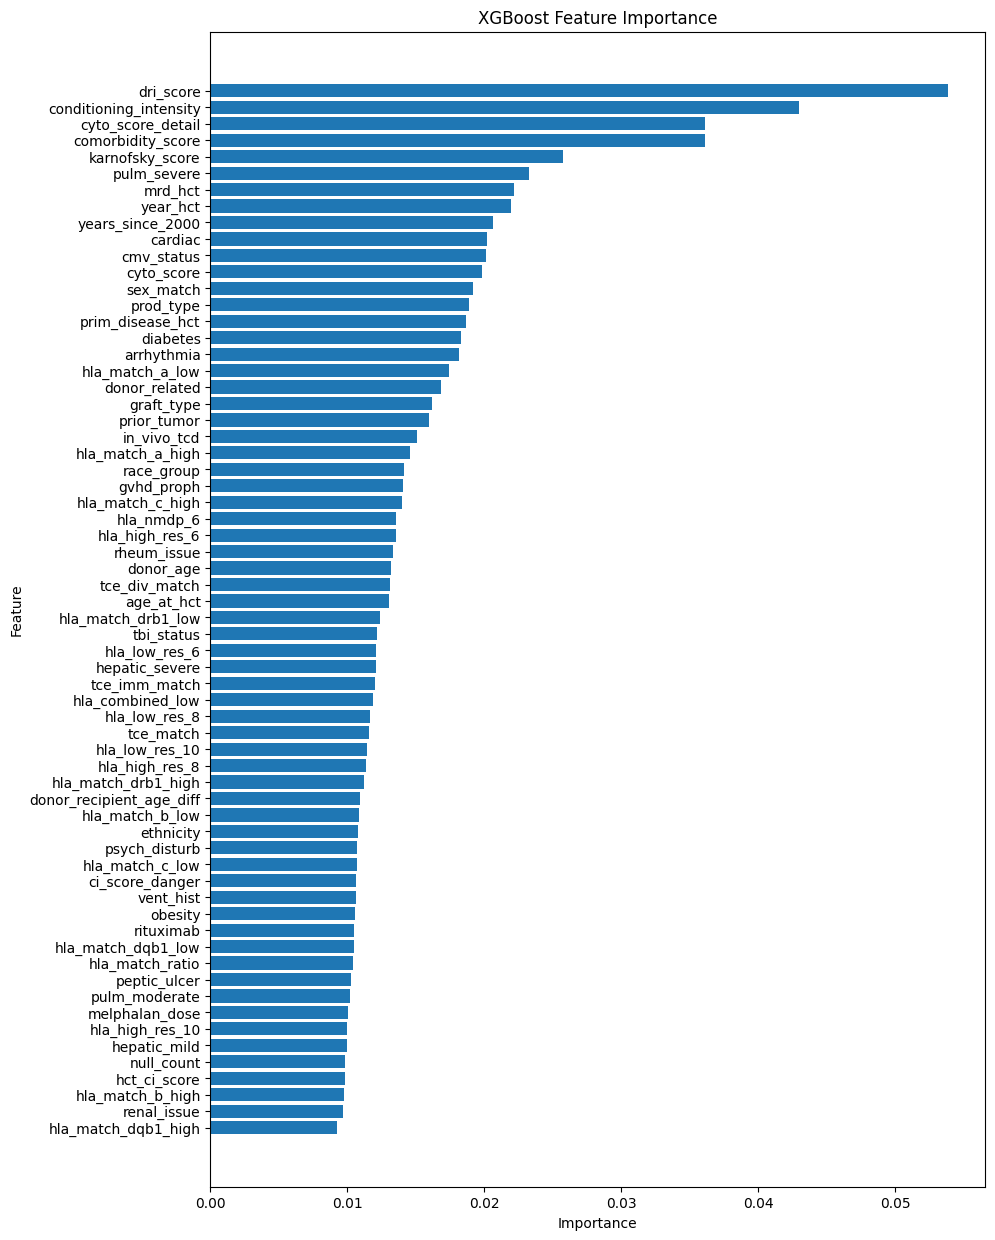

In [52]:
feature_importance = model_xgb.feature_importances_
importance_df = pd.DataFrame({
    "Feature": FEATURES,  # Replace FEATURES with your list of feature names
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.show()

In [53]:
from catboost import CatBoostRegressor, CatBoostClassifier
import catboost
# print("Using CatBoost version",catboost.__version__)
FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat = np.zeros(len(train))
pred_cat = np.zeros(len(test))
cat_params = {
        "iterations": 1000,
        "depth": 6,
        "learning_rate": 0.2,
        "l2_leaf_reg": 5,
        "random_seed": 42,
        "task_type": "CPU",
        "verbose": 100
    }

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(**cat_params, cat_features=CATS)
    model_cat.fit(
        x_train,
        y_train,
        eval_set=(x_valid, y_valid),
    )

    # INFER OOF
    oof_cat[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.1736528	test: 0.1728237	best: 0.1728237 (0)	total: 82.9ms	remaining: 1m 22s
100:	learn: 0.1517362	test: 0.1568583	best: 0.1568583 (100)	total: 7.75s	remaining: 1m 8s
200:	learn: 0.1463981	test: 0.1560649	best: 0.1560416 (197)	total: 14.7s	remaining: 58.6s
300:	learn: 0.1421081	test: 0.1555952	best: 0.1555808 (295)	total: 21.8s	remaining: 50.6s
400:	learn: 0.1391483	test: 0.1556127	best: 0.1555808 (295)	total: 28.9s	remaining: 43.2s
500:	learn: 0.1363291	test: 0.1555111	best: 0.1554926 (493)	total: 36.4s	remaining: 36.3s
600:	learn: 0.1337275	test: 0.1554925	best: 0.1554347 (519)	total: 44s	remaining: 29.2s
700:	learn: 0.1311837	test: 0.1556139	best: 0.1554270 (631)	total: 51s	remaining: 21.8s
800:	learn: 0.1284520	test: 0.1557377	best: 0.1554270 (631)	total: 58.1s	remaining: 14.4s
900:	learn: 0.1264829	test: 0.1559235	best: 0.1554270 (631)	total: 1m 5s	remaining: 7.16s
999:	learn: 0.1243884	test: 0.1561271	best:

In [54]:
bin_pred_np = np.array(bin_pred)
oof_cat_np = np.array(oof_cat)

combined_array_cat = np.column_stack((bin_pred_np, oof_cat_np))

print(combined_array)  # (2, 28800)

[[0.         0.48223439]
 [1.         0.72817585]
 [0.         0.43573365]
 ...
 [1.         0.7665799 ]
 [0.         0.55893451]
 [0.         0.5010094 ]]


In [55]:
data_0 = combined_array_cat[combined_array_cat[:, 0] == 0]
data_1 = combined_array_cat[combined_array_cat[:, 0] == 1]
combined_array_cat[combined_array_cat[:, 0] == 1, 1] += 0.1

In [56]:
data_0 = combined_array_cat[combined_array_cat[:, 0] == 0]
data_1 = combined_array_cat[combined_array_cat[:, 0] == 1]

In [57]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = combined_array_cat[:, 1]

# print(y_pred)
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost =",m)


Overall CV for CatBoost = 0.6798538836070089


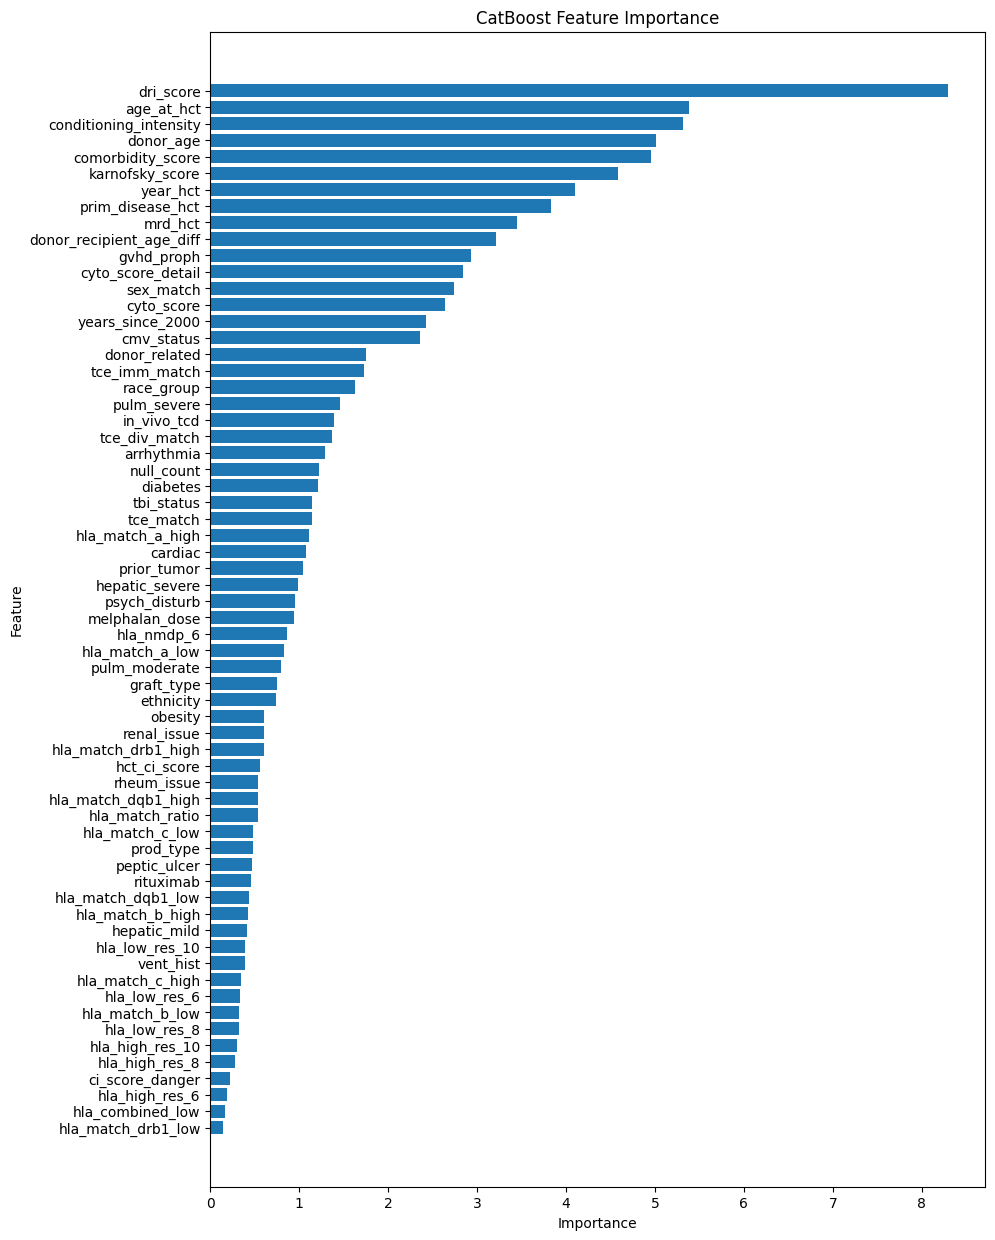

In [58]:
feature_importance = model_cat.get_feature_importance()
importance_df = pd.DataFrame({
    "Feature": FEATURES, 
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.show()

In [59]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = combined_array[:, 1] + combined_array_cat[:, 1]
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for Ensemble =",m)


Overall CV for Ensemble = 0.6818273224791944


In [60]:
prediction = pred_xgb + pred_cat

pred_classifier_np = np.array(pred_classifier)
prediction_np = np.array(prediction)

combined_pred = np.column_stack((pred_classifier_np, prediction_np))
print(combined_pred)  # (2, 3)

combined_pred[combined_pred[:, 0] == 1, 1] += 0.1
print(combined_pred)  # (2, 3)


sub = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv")
sub.prediction = combined_pred[:, 1]

print(sub)

[[0.         0.97105861]
 [1.         1.3757363 ]
 [0.         0.87676518]]
[[0.         0.97105861]
 [1.         1.4757363 ]
 [0.         0.87676518]]
      ID  prediction
0  28800    0.971059
1  28801    1.475736
2  28802    0.876765


In [61]:
sub.to_csv("submission3.csv",index=False)
print("Sub shape:",sub.shape)
sub.head()

Sub shape: (3, 2)


,ID,prediction
0,28800,0.971059
1,28801,1.475736
2,28802,0.876765


---

# **Ensemble Notebook**

In [ ]:
import pandas as pd
from scipy.stats import rankdata

# Load submission files
sub1 = pd.read_csv('/kaggle/working/submission1.csv')
sub2 = pd.read_csv('/kaggle/working/submission2.csv')
sub3 = pd.read_csv('/kaggle/working/submission3.csv')

# Calculate ranks for each submission's predictions
rank1 = rankdata(sub1['prediction'], method='average')
rank2 = rankdata(sub2['prediction'], method='average') 
rank3 = rankdata(sub3['prediction'], method='average')

rank_df = pd.DataFrame({
    'rank1': rank1,
    'rank2': rank2,
    'rank3': rank3,
})
ensemble_rank = rank_df.mean(axis=1)

# Create final submission file with averaged ranks
final_sub = sub1[['ID']].copy()
final_sub['prediction'] = ensemble_rank
final_sub.to_csv('submission.csv', index=False)